In [76]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み、一行目はヘッダーじゃない
#df = pd.read_csv("../../../dataset/ransuu.csv",header=None)
iris = pd.read_csv("../../../dataset/iris-dataset.csv")
df = iris.drop('species', axis=1)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape
#クラスタ数宣言
c = 3
#Kはクラスタサイズ 
K = X_size /c
#交互最適化最大繰り返し数
max_iter = 100

#正則化パラメーター設定
lam = 100
lam_1= 1/lam
#kappa指定
a = 0.15
b = 0.20
#初期値繰り返し回数
NumberOfRepetitions= 50
#各変数の初期値格納
distances=np.zeros((X_size,c))
epsilon = np.zeros((X_size,dimension))
#best_J = 100000000

In [78]:
lam_1

0.01

In [79]:
#許容範囲epsilonの作成
def CreateEpsilon(a,b,X_size,dimension):
    #許容ベクトルepsilonの初期値を設定
    #任意の範囲（[a, b): a以上、b未満）の乱数を取得したい場合
    kappa = (b - a) * np.random.rand(X_size,dimension) + a
    epsilon = np.zeros((X_size,dimension))
    for i in range(X_size):
        for j in range(dimension):
            ep_max = kappa[i][j]
            epsilon[i][j] = (ep_max + ep_max) * np.random.rand() - ep_max
    #print(kappa[0])
    #print(epsilon[0])
    #_________________________________________
    return kappa,epsilon

In [80]:
def calculate_ep(X,u):
    #_____________epsilonの更新用に定義______________
    X_size,dimension = X.shape
    new_epsilon = np.zeros((X_size,dimension))

   #_____________not_alpha作成部分__________________
    not_alpha = np.zeros((X_size,dimension))
    for k in range(X_size):
        for j in range(dimension):
            sum_uv = 0
            for i in range(c):
                sum_uv +=u[k][i]*centroids[i][j]
            not_alpha[k][j]= X[k][j]-sum_uv
    ep_denominator = np.abs((not_alpha)*-1)
    alpha_kari = kappa/ep_denominator
    #______________epsilonの更新_t__________________
    for i in range(X_size):
        for j in range(dimension):
            if alpha_kari[i][j] < 1:
                new_epsilon[i][j] = alpha_kari[i][j]*not_alpha[i][j]*-1
            else:
                new_epsilon[i][j] = not_alpha[i][j]*-1
    return new_epsilon

In [81]:
#uの最適化部分関数作成
def u_optimize(d,c,lam_1):
    #変数定義
    u_list = [0] * len(d)
    for i in range(len(d)):
        u_list[i] = cp.Variable()
    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += u_list[i]*d[i]-lam_1*(cp.entr(u_list[i]))
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    Positive_Number = []
    Total_1 = []
    Total_K = []
    constraints = []
    #0以上
    for i in range (len(d)):
        Positive_Number.append(u_list[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        sum_iti = 0
        for j in range(c):    
            sum_iti += u_list[i+j]
        Total_1.append(sum_iti==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    Total_K.append(sum(u_list[0:len(d):c])==K)
    Total_K.append(sum(u_list[1:len(d):c])==K)
    # Total_K.append(sum(u_list[2:len(d):c])==K)
    # Total_K.append(sum(u_list[3:len(d):c])==K)
    # Total_K.append(sum(u_list[4:len(d):c])==K)
    constraints.extend(Positive_Number)
    constraints.extend(Total_1)
    constraints.extend(Total_K)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u_list[i].value)
    u_array = u_value.reshape([X_size,c])
    #u_arrayに帰属度配列、resultに目的関数
    return u_array,result

In [82]:
#クラスタ中心計算部分関数作成
def v_calculation(u,c,dimension,X,epsilon):
    #分子計算
    v_numerator = np.zeros((c,dimension))
    for j in range(c):
        for i in range(X_size):
            v_numerator[j]+= u[i][j]*(X[i]+epsilon[i])
   
    v = np.zeros((c,dimension ))
    for i in range(c):
        v[i] = v_numerator[i]/K
    return v

In [83]:
for s in range (NumberOfRepetitions):
    print(f"{s+1}回目")
    centroids = X[np.random.choice(X_size,c)]
    kappa,epsilon = CreateEpsilon(a,b,X_size,dimension)       
            
    for epoch in range(max_iter):
        #print(f"{epoch+1}回目")
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]+epsilon[i]-centroids[j])**2))
        #uの更新
        u,J = u_optimize(d,c,lam_1)
        #vの更新
        new_centroids = v_calculation(u,c,dimension,X,epsilon)
        #epsilonの更新
        epsilon = calculate_ep(X,u)
        #print(epsilon[0])
        
        # もしも重心が変わっていなかったら終了
        if np.sum(np.abs(new_centroids-centroids))<=0.000001:
            #print(new_centroids-centroids)
            print("中心が変わらないのでbreakします！")
            break
        centroids = np.copy(new_centroids)

    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if s == 0:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    if best_J > J:
        np_cluster = np.argmax(u,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    print(f"{s+1}回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(f"epsilon[0]:{epsilon[0]}")
print(np_cluster)
print(best_J)
print(best_centroids)

1回目
中心が変わらないのでbreakします！
1回目のクラスタリング結果↓
inf
[[5.86773242 2.74338607 4.21564658 1.37342103]
 [5.00505394 3.4316943  1.47531861 0.29403311]
 [6.68513074 2.9829149  5.58306149 1.99389573]]
終了
2回目
2回目のクラスタリング結果↓
inf
[[5.86773242 2.74338607 4.21564658 1.37342103]
 [5.00505394 3.4316943  1.47531861 0.29403311]
 [6.68513074 2.9829149  5.58306149 1.99389573]]
終了
3回目
3回目のクラスタリング結果↓
inf
[[5.86773242 2.74338607 4.21564658 1.37342103]
 [5.00505394 3.4316943  1.47531861 0.29403311]
 [6.68513074 2.9829149  5.58306149 1.99389573]]
終了
4回目
4回目のクラスタリング結果↓
inf
[[5.86773242 2.74338607 4.21564658 1.37342103]
 [5.00505394 3.4316943  1.47531861 0.29403311]
 [6.68513074 2.9829149  5.58306149 1.99389573]]
終了
5回目
5回目のクラスタリング結果↓
inf
[[5.86773242 2.74338607 4.21564658 1.37342103]
 [5.00505394 3.4316943  1.47531861 0.29403311]
 [6.68513074 2.9829149  5.58306149 1.99389573]]
終了
6回目
6回目のクラスタリング結果↓
inf
[[5.86773242 2.74338607 4.21564658 1.37342103]
 [5.00505394 3.4316943  1.47531861 0.29403311]
 [6.68513074 2.9829149 

In [84]:
best_J

inf

In [85]:
print("帰属度とクラスタサイズの確認")
print(np.sum(u, axis=1))#行ごとの合計値1になるはず
print(np.sum(u, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
[49.99999999 49.99999999 49.99999999]


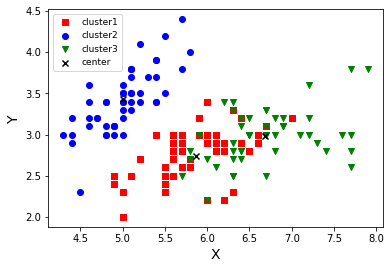

In [86]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3',"center"],fontsize=9)  # 凡例を表示

plt.show()

#fig.savefig("kkt_entropy_10.pdf")

In [87]:
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))
print(np.count_nonzero(np_cluster==3))
print(np.count_nonzero(np_cluster==4))

50
50
50
0
0


0と1の交換

In [89]:
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==1, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==0, 1, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==100, 0, cluster_hensyuu_1)

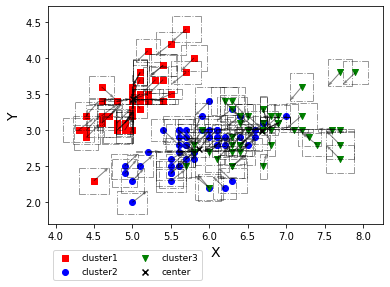

In [94]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][cluster_hensyuu_2==i], X[:, 1][cluster_hensyuu_2==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示
#______
for i in range(X_size):
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]-epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]+epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]-epsilon[i][0],X[i][0]-epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)
    ax.plot([X[i][0]+epsilon[i][0],X[i][0]+epsilon[i][0]],[X[i][1]-epsilon[i][1],X[i][1]+epsilon[i][1]],color="black",linestyle="dashdot",linewidth = 1, alpha = 0.4)

    ax.quiver(X[i][0], X[i][1], epsilon[i][0], epsilon[i][1], angles='xy', scale_units='xy', scale=1,width=0.003,alpha=0.5) # 矢印プロット
#______

plt.show()

fig.savefig("ToleFecE100_Iris.pdf",bbox_inches='tight')

In [95]:
fig.savefig("ToleFecE100_Iris.pdf",bbox_inches='tight')

In [93]:
#------正解率の算出
dff = pd.read_csv("../../dataset/iris-dataset.csv")
size_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
seikai = iris["species"].map(size_mapping).values

seikaisuu = np.count_nonzero(cluster_hensyuu_2==seikai)
seikairitu= (np.count_nonzero(cluster_hensyuu_2==seikai))/X_size*100
print("正解率")
print(seikairitu)
print("正解数")
print(seikaisuu)
print("クラスタサイズ確認")
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))

正解率
93.33333333333333
正解数
140
クラスタサイズ確認
50
50
50


## ここまでが完成コード

In [96]:
np_cluster

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [97]:
cluster_hensyuu_2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [98]:
seikai

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [235]:
#テスト用セル
#uの最適化部分関数作成
def u_optimize(d,J):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()
    #uの最適化
    # 最小化したい関数 (目的関数)
    Objective_function = 0
    for i  in range(len(d)):
        #Objective_function += d[i]*cp.power(u[i],8)
        Objective_function += u[i]*d[i]-cp.entr(u[i])
    objective = cp.Minimize(Objective_function)
    
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    J = np.append(J,result)
    return u,J
centroids = X[np.random.choice(X_size,c)]
J = np.empty(0)
#dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
d=[]
for i in range(X_size):
    for j in range(c):
        d.append(np.sum((X[i]-centroids[j])**2))
#uの更新
optimize_result = u_optimize(d,J)
u_value = optimize_result[0]
u_list = u_value.reshape([99,5])
print(optimize_result[0])
print(optimize_result[1])

ValueError: cannot reshape array of size 375 into shape (99,5)

In [222]:
print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
[19.8 19.8 19.8 19.8 19.8]


In [265]:
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))
print(np.count_nonzero(np_cluster==3))
print(np.count_nonzero(np_cluster==4))

21
21
21
21
15


In [272]:
row_swap = best_centroids[[4,1,2,3,0]]
row_swap

array([[0.35337731, 0.50077248],
       [0.5162733 , 0.50885754],
       [0.505059  , 0.69441529],
       [0.49944437, 0.30542704],
       [0.70362389, 0.50555305]])

In [273]:
best_centroids

array([[0.70362389, 0.50555305],
       [0.5162733 , 0.50885754],
       [0.505059  , 0.69441529],
       [0.49944437, 0.30542704],
       [0.35337731, 0.50077248]])

In [247]:
#作業用セル(使用中)(制約条件変更中)（12/13）
centroids = X[np.random.choice(X_size,c)]
#dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
d=[]
for i in range(X_size):
    for j in range(c):
        d.append(np.sum((X[i]-centroids[j])**2))
#uの最適化
u = [0] * len(d)
#変数定義
for i in  range (len(d)):
    u[i] = cp.Variable()
#目的関数定義
Objective_function = 0 
for i  in range(len(d)):
    Objective_function += d[i]*cp.power(u[i],3)
objective = cp.Minimize(Objective_function)
# 制約条件の定義
zeroijou = []
goukeiiti = []
goukeigo = []
constraints = []
#0以上
for i in range (len(d)):
    zeroijou.append(u[i]>=0)
#合計1
for i in range (0,len(d),c):
    #下の式はcの値によって逐次変更しないといけない
    goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
#合計がクラスタサイズ
#下の式はcの値によって逐次変更しないといけない
goukeigo.append(sum(u[0:len(d):c])==K)
goukeigo.append(sum(u[1:len(d):c])==K)
goukeigo.append(sum(u[2:len(d):c])==K)
goukeigo.append(sum(u[3:len(d):c])==K)
goukeigo.append(sum(u[4:len(d):c])==K)
constraints.extend(zeroijou)
constraints.extend(goukeiiti)
constraints.extend(goukeigo)

# 問題を定義
problem = cp.Problem(objective, constraints)
# 最適化 (戻り値は最適化後に得られた値=最小値)
result = problem.solve()

#帰属度uと目的関数Jの値を抽出(ndarray型)
u_value = np.empty(0)#空のndarrayを作成
for i in range (len(d)):
    u_value = np.append(u_value,u[i].value)

u_list = u_value.reshape([99,5])

print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
[19.8 19.8 19.8 19.8 19.8]


In [250]:
#uの最適化部分関数作成
def u_optimize(d,J):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u[i],3)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    J = np.append(J,result)
    return u,J
#クラスタ中心計算部分関数作成
#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [269]:
u_list

array([[5.73688804e-03, 7.64896875e-01, 9.17422819e-03, 6.20765489e-03,
        2.13984354e-01],
       [3.08902944e-04, 4.70057913e-02, 9.43168621e-01, 1.11571774e-07,
        9.51657330e-03],
       [2.93697931e-04, 3.43103032e-02, 2.46001180e-07, 9.52132392e-01,
        1.32633610e-02],
       [9.30150496e-01, 6.90067948e-02, 5.28480759e-04, 2.85661520e-04,
        2.85664281e-05],
       [2.19418975e-08, 5.26059951e-03, 9.88169136e-05, 8.36998720e-05,
        9.94556862e-01],
       [1.32468128e-02, 8.44969345e-01, 1.91339295e-02, 3.04081359e-03,
        1.19609099e-01],
       [1.08571681e-02, 8.30652016e-01, 1.39619841e-02, 4.26696456e-03,
        1.40261868e-01],
       [2.56428399e-03, 6.54333159e-01, 5.63170091e-03, 8.46063448e-03,
        3.29010222e-01],
       [7.43184007e-03, 7.89796374e-01, 5.87939491e-03, 1.04516474e-02,
        1.86440743e-01],
       [1.36933887e-02, 8.47080142e-01, 1.97477731e-02, 2.93845526e-03,
        1.16540241e-01],
       [5.51154026e-03, 7.6149

In [153]:
np_cluster_kai1 = np.where(np_cluster==2, 1, np_cluster_kai)

In [154]:
np_cluster_kai1 

array([0, 1, 0, 3, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [155]:
np_cluster_kai2 = np.where(np_cluster==3, 2, np_cluster_kai1)

In [156]:
np_cluster_kai2

array([0, 1, 0, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [157]:
print(np.count_nonzero(np_cluster_kai2==0))
print(np.count_nonzero(np_cluster_kai2==1))
print(np.count_nonzero(np_cluster_kai2==2))
print(np.count_nonzero(np_cluster_kai2==3))
print(np.count_nonzero(np_cluster_kai2==4))

41
49
9
0
0
